In [1]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding 
from keras.layers import LSTM 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
print("tensorflow version %s (should be at least 0.12.1)" % tf.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

NameError: name 'tf' is not defined

## <font color=darkred> Data exploration </font>

In [8]:
#Importation du document sur le Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Maths 4102/Projet Deep Learning 2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pollution.csv  projet_deep_learning_II.ipynb


In [0]:
# load dataset
raw_data = pd.read_csv('/content/drive/My Drive/Maths 4102/Projet Deep Learning 2/pollution.csv', header=0, index_col=0)
values = raw_data.values

This dataset provides hourly weather conditions and pollution levels for  five years at the US embassy in Beijing, China.

The complete feature list in the raw data is as follows:

``No``: row number

``year``: year of data in this row

``month``: month of data in this row

``day``: day of data in this row

``hour``: hour of data in this row

``pm2.5``: PM2.5 concentration i.e. pollution level

``DEWP``: Dew Point

``TEMP``: Temperature

``PRES``: Pressure

``cbwd``: Combined wind direction

``Iws``: Cumulated wind speed

``Is``: Cumulated hours of snow

``Ir``: Cumulated hours of rain

In [10]:
raw_data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


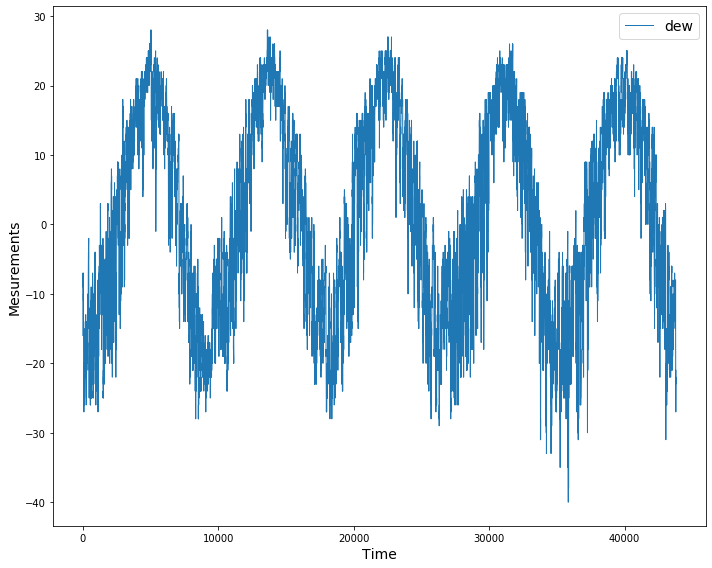

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(values[:, 1], lw=1, label=raw_data.columns[1])
plt.legend(fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()

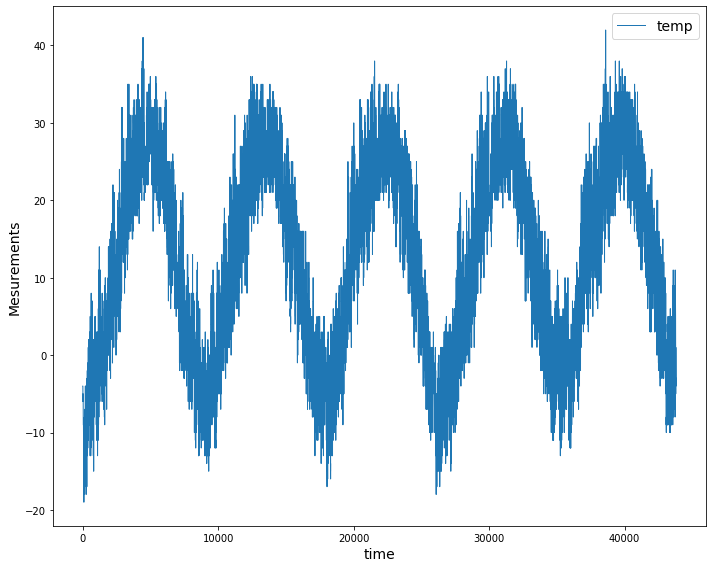

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(values[:, 2], lw=1, label=raw_data.columns[2])
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()

**Questions**

Display the pollution level as a function of time.

Use the ``heatmap`` function to display the correlation of the data.

Display boxplots of the pollution values as a function of other variables values
(This may help to detect useless features for prediction).


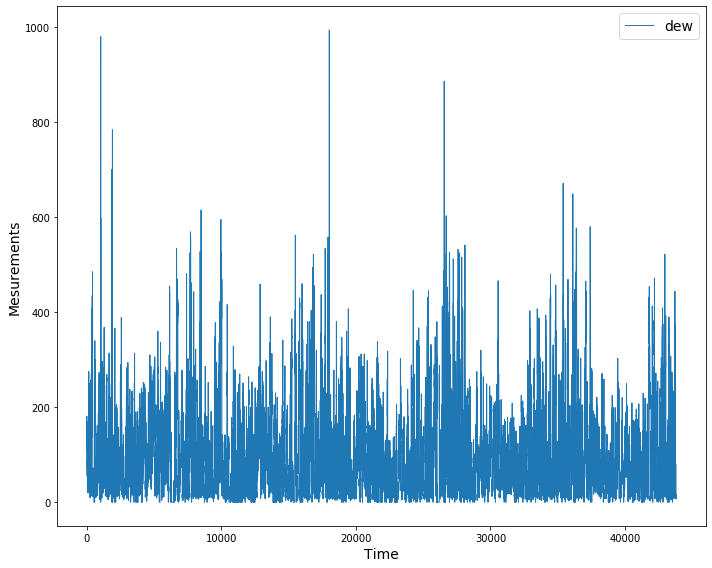

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(values[:, 0], lw=1, label=raw_data.columns[1])
plt.legend(fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mesurements', fontsize=14)
plt.tight_layout()

#Nb : le temps est représenté par le nombre d'heure passée depuis le 2010-01-02

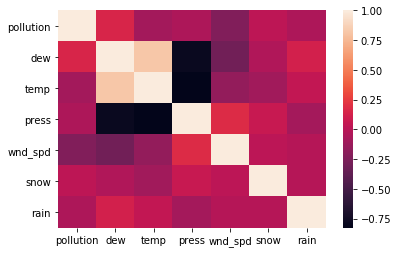

In [14]:
import seaborn as sns
corr = raw_data.corr()
sns.heatmap(corr)

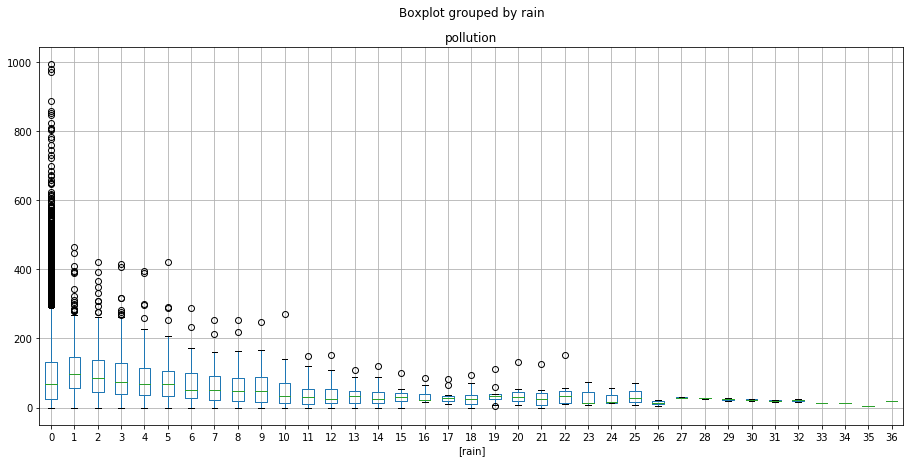

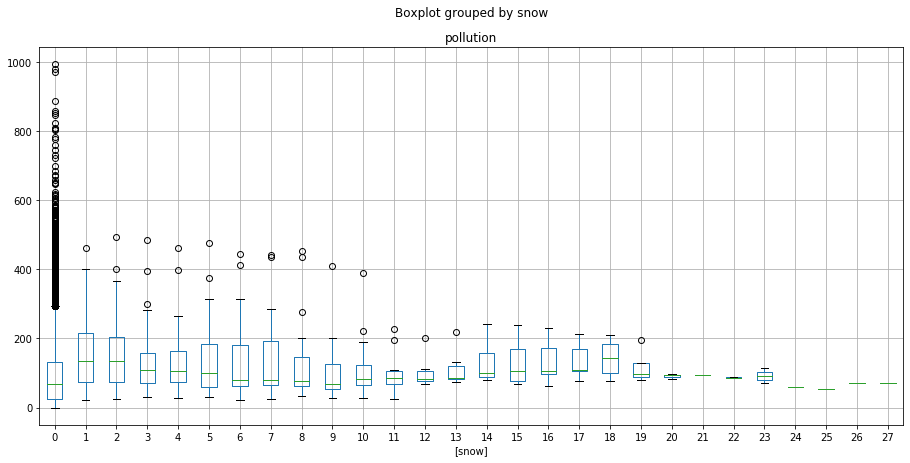

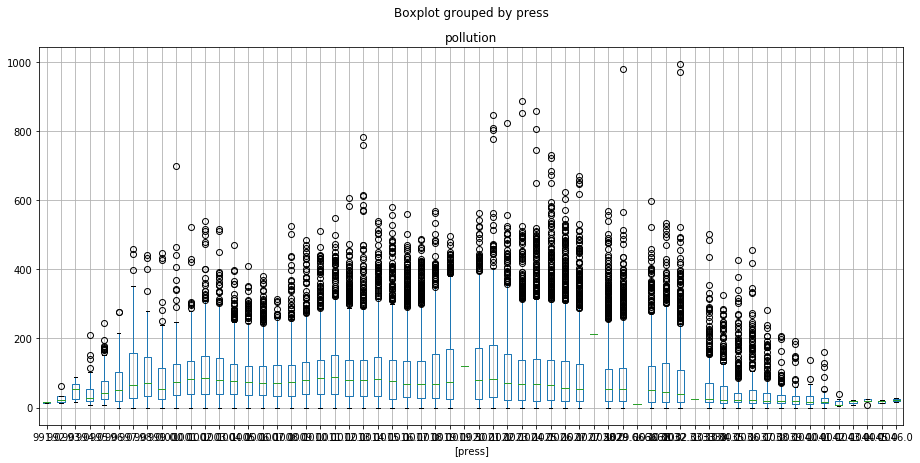

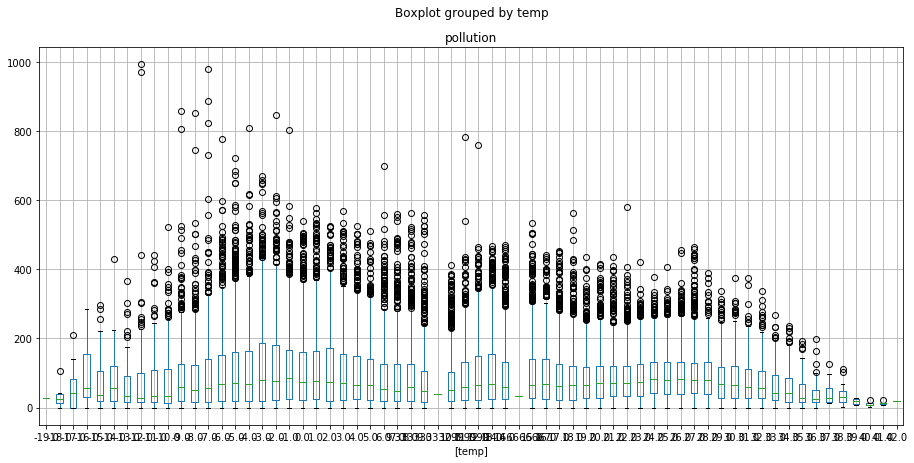

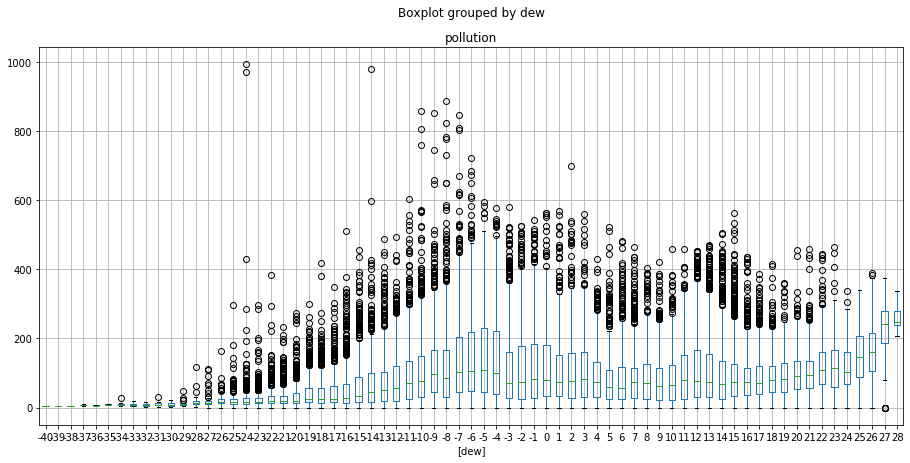

In [15]:
# Some boxplots displaying the distribution of a feature within each category.
# This may help to detect useless features for classification... or a feature highly impacted by the category.
raw_data.boxplot('pollution', by=['rain'],figsize=(15,7))
##
# Faire des recherches sur la doc de boxplot
##
raw_data.boxplot('pollution', by=['snow'],figsize=(15,7))
#raw_data.boxplot('pollution', by=['wnd_spd'],figsize=(15,7))
raw_data.boxplot('pollution', by=['press'],figsize=(15,7))
raw_data.boxplot('pollution', by=['temp'],figsize=(15,7))
raw_data.boxplot('pollution', by=['dew'],figsize=(15,7))

**Commentaire**

On peut voir ici que les valeurs des différentes données influent et font varier la pollution.

D'une part, on peut se dire en constatant certains graphes que l'on aurait pu faire du clustering : par exemple, avec les cas de la pollution en fonction de la neige, que l'on aurait pu créer des catégories pour avoir un avis plus global. On peut imaginer une catégorie faiblement eneigé, une fortement eneigé et d'autre cas extrêmes ou intermédiraires.

Ensuite, comme on voit que certains cas possèdent des boites qui ne sont pas les mêmes partout sur la distribution : cela signifie que les paramètres ont bel et bien une influence sur la pollution.


## <font color=darkred> Pre-processing </font>

Pre-processing from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Design which data to use as inputs and which as outputs.

This function gets rid of NaN values.

It may be skipped during the first read. The only crucial feature is the ``n_in`` parameters which states the number of previous time steps to consider in the input data.

The objective of this project is to predict the pollution level $y_t$ at time $t$ from previous observations.
Simple recurrent neural networks and Long Short-Term memory will be considered. At each time step the estimate $\hat{y}_t$ is obtained using a hidden state $h_{t-1}$ computed on the fly and input data $x_t$ at time $t$. 

The function ``build_dataset`` provives the values of $y_t$ in the last column and the values of the input $x_t$ in all the other columns.

If $n_{in} = 1$, $x_t$ is made of all measurements at time $t-1$.

If $n_{in} = 2$, $x_t$ is made of all measurements at time $t-2$...

In [0]:
from tkinter import Frame
from tkinter import Text
from tkinter import Label

In [0]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [18]:
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# parameter to design how many time steps to consider in the input data
time_lag = 1
processed_data = build_dataset(scaled, time_lag, 1)

# drop useless columns
processed_data.drop(processed_data.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
processed_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [0]:
# split into train and test sets
values = processed_data.values

# number of years to use for training
nb_years = 3
n_train_hours = nb_years*365 * 24

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [20]:
print('x_train shape:', train_X.shape)
print('x_test shape:', test_X.shape)
print('y_train shape:', train_y.shape)
print('y_test shape:', test_y.shape)

x_train shape: (26280, 1, 8)
x_test shape: (17519, 1, 8)
y_train shape: (26280,)
y_test shape: (17519,)


In [21]:
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

26280 train samples
17519 test samples


In [22]:
input_shape = (train_X.shape[1], train_X.shape[2])
input_shape

(1, 8)

## <font color=darkred> Feed Forward Neural Network </font>

In [0]:
from random import randint
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations
import numpy as np
import matplotlib.pyplot as plt

**Question**

Define a FFNN model with one hidden layer

In [24]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape = input_shape))
model_ffnn.add(Dense(32, activation='relu'))
model_ffnn.add(Dense(1, activation='linear'))

#On propose de prendre 10 classes

###
#model_ffnn.add(Dense(1, activation='softmax'))
###

model_ffnn.compile(
    loss='mae',
    optimizer=keras.optimizers.Adagrad(),
    metrics=['mean_squared_error']
)

model_ffnn.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [25]:
batch_size = 64
epochs = 50
history = model_ffnn.fit(train_X, train_y,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(test_X, test_y))




Train on 26280 samples, validate on 17519 samples
Epoch 1/50





26280/26280 [==============================] - 1s 44us/step - loss: 0.0336 - mean_squared_error: 0.0054 - val_loss: 0.0164 - val_mean_squared_error: 8.0541e-04
Epoch 2/50
26280/26280 [==============================] - 1s 25us/step - loss: 0.0158 - mean_squared_error: 8.5273e-04 - val_loss: 0.0146 - val_mean_squared_error: 7.4006e-04
Epoch 3/50
26280/26280 [==============================] - 1s 25us/step - loss: 0.0148 - mean_squared_error: 8.1573e-04 - val_loss: 0.0142 - val_mean_squared_error: 7.3325e-04
Epoch 4/50
26280/26280 [==============================] - 1s 25us/step - loss: 0.0144 - mean_squared_error: 8.0230e-04 - val_loss: 0.0139 - val_mean_squared_error: 7.2306e-04
Epoch 5/50
26280/26280 [==============================] - 1s 27us/step - loss: 0.0142 - mean_squared_error: 7.9513e-04 - val_loss: 0.0139 - val_mean_squared_error: 7.1936e-04
Epoch 6/50
26280/26280 [==============================] - 1s 26us/step 

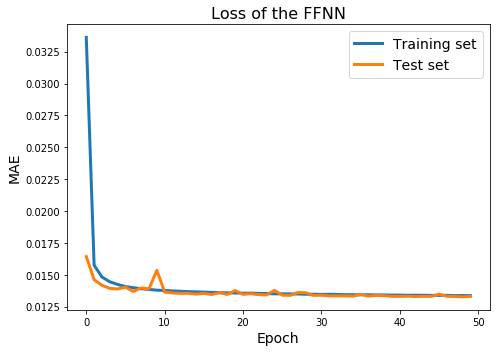

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.title('Loss of the FFNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

**Commentaire**

On a réalisé ici un apprentissage avec, comme suggéré par les commentaires, une couche cachée suivant une méthode linéaire. Pour cela, on réalise un apprentissage et on garde une batteir de données pour pouvoir faire une zone de test. 

Ainsi, on voit qu'avec cette méthode, et avec le nombre d'epoch grandissant , la courbe va tendre vers la courbe d'entrainement.

## <font color=darkred> Recurrent Neural Networks</font>

At time $t$ the hidden state of the network is computed as follows:

$h_t = \sigma_h(W_x\,{x_t} + W_h\,{h_{t-1}} + b_h)$, where $\sigma_h$ is a nonlinear activation function, e.g. $\mathrm{tanh}$, $x_t$ is the input at time $t$ and $h_{t-1}$ is the hidden state at the previous time step.

$W_x$, $b_h$ and $W_h$ are the unknown parameters of the state update.

The predicted output is:

$\widehat{y}_t = \sigma_y(W_y\,{h_t} + b_y)\,,$

where $\sigma_y$ is the output activation function and $W_y$ and $b_y$ are the unknown parameters of the prediction step.

**Question**

Define a RNN model with one hidden layer ``SimpleRNN``

In [27]:
from keras.layers.recurrent import SimpleRNN
model_rnn = Sequential()

model_rnn.add(SimpleRNN(32,input_shape=(train_X.shape[1], train_X.shape[2])))  
model_rnn.add(Dense(1, activation='linear'))

model_rnn.compile(loss='mae', optimizer='adam')

model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [28]:
batch_size = 64
epochs = 50
history = model_rnn.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, validation_data=(test_X, test_y), verbose=1)

Train on 26280 samples, validate on 17519 samples
Epoch 1/50
26280/26280 [==============================] - 1s 44us/step - loss: 0.0625 - val_loss: 0.0137
Epoch 2/50
26280/26280 [==============================] - 1s 31us/step - loss: 0.0140 - val_loss: 0.0144
Epoch 3/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0140 - val_loss: 0.0135
Epoch 4/50
26280/26280 [==============================] - 1s 30us/step - loss: 0.0141 - val_loss: 0.0140
Epoch 5/50
26280/26280 [==============================] - 1s 32us/step - loss: 0.0139 - val_loss: 0.0138
Epoch 6/50
26280/26280 [==============================] - 1s 32us/step - loss: 0.0140 - val_loss: 0.0141
Epoch 7/50
26280/26280 [==============================] - 1s 30us/step - loss: 0.0140 - val_loss: 0.0136
Epoch 8/50
26280/26280 [==============================] - 1s 31us/step - loss: 0.0139 - val_loss: 0.0132
Epoch 9/50
26280/26280 [==============================] - 1s 30us/step - loss: 0.0139 - val_loss: 0.0142
Epoch

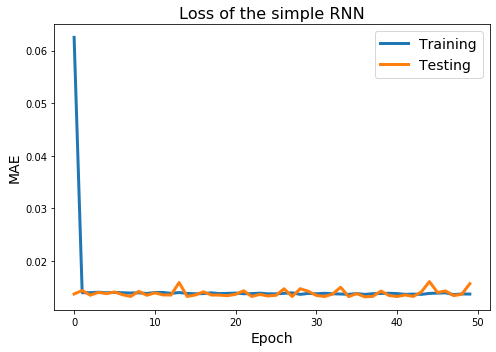

In [29]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of the simple RNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

**Commentaire**

Dans ce cas-ci, on peut voir que l'on a, comme pour le cas précédent, une courbe qui est assez éloignée au départ et qui va ensuite tendre vers une valeur moyenne de la courbe de tests.

On peut lire dans le code executé que l'on a une perte moyenne qui est d'environ 1,5%. Ainsi, on voit que ce modèle avec une couche permet de préduire de manière fidèle le résultat, et cela en connaissant les états précédents.

## <font color=darkred> Long Short-Term memory </font>

The LSTM cell is a more complex recurrent neural network. It contains three gates, input, forget, output gates and a memory cell i.e. several hidden transformations to process the hidden state and the input. 

The first transforms at time $t$ are: 

$i_t = \sigma ( W_i [h_{t-1}, x_t] + b_i)$, $f_t = \sigma ( W_f [h_{t-1},x_t] + b_f)$, $o_t = \sigma ( W_o [h_{t-1},x_t] + b_o)$,

where $W_i, W_f, W_o$, $b_i$, $b_f$ and $b_o$ are the unknown parameters (applied to the concatenation of $h_{t-1}$ (hidden state vector) and $x_t$ (input vector)).

The previous hidden state $h_{t-1}$ and the current input $x_t$ are used to compute the a candidate $g_t$:

$g_t = \mathrm{tanh}( W_g [h_{t-1}, x_t] + b_g)\,.$

The cell memory $c_t$, is updated as:

$c_t = c_{t-1} \circ f_t + g_t \circ i_t\,,$

where $c_{t-1}$ is the previous memory, and $\circ$ refers to element-wise multiplication.

The output, $h_t$, is computed as

$h_t = \mathrm{tanh}(c_t) \circ o\,.$

The predicted output is:

$\widehat{y}_t = \sigma_y(W_y\,{h_t} + b_y)\,,$

where $\sigma_y$ is the output activation function and $W_y$ and $b_y$is the unknown parameter of the prediction step.

**Question**

Define a LSTM model with one hidden layer

In [30]:
model = Sequential()

model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                760       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 771
Trainable params: 771
Non-trainable params: 0
_________________________________________________________________


In [31]:
batch_size = 64
epochs = 50
history = model.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, validation_data=(test_X, test_y), verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 26280 samples, validate on 17519 samples
Epoch 1/50
26280/26280 [==============================] - 2s 72us/step - loss: 0.0597 - val_loss: 0.0287
Epoch 2/50
26280/26280 [==============================] - 1s 49us/step - loss: 0.0164 - val_loss: 0.0139
Epoch 3/50
26280/26280 [==============================] - 1s 47us/step - loss: 0.0138 - val_loss: 0.0135
Epoch 4/50
26280/26280 [==============================] - 1s 45us/step - loss: 0.0137 - val_loss: 0.0137
Epoch 5/50
26280/26280 [==============================] - 1s 47us/step - loss: 0.0136 - val_loss: 0.0134
Epoch 6/50
26280/26280 [==============================] - 1s 50us/step - loss: 0.0135 - val_loss: 0.0134
Epoch 7/50
26280/26280 [==============================] - 1s 45us/step - loss: 0.0134 - val_loss: 0.0133
Epoch 8/50
26280/26280 [==============================] - 1s 47us/step - loss: 0.0135 - val_loss: 0.0135
Epoch 9/50
26280

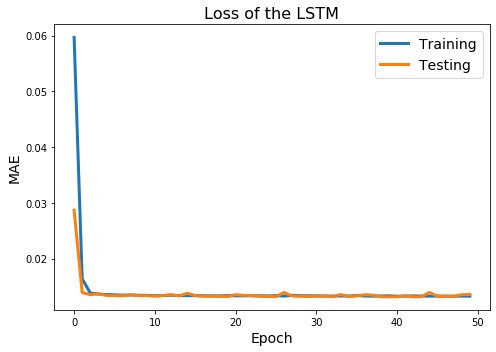

In [32]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Loss of the LSTM', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.tight_layout()

**Questions**

Use a cross-validation to select the best LSTM and best RNN networks (with respect to the dimension of the hidden state) dimension.

Analyze the impact of the lag in the input sequence (i.e. if $x_t$ contains the features at times $t-1$, $t-2$, $t-3$) by using the function ``build_dataset`` with another parameter.

Analyze the sensitiviy of the LSTM with respect to initialization (by training several independent LSTM models).

Use the predict function to predict the observations $y$ associated with the input data in ``test_X``. Display these predictions with the true pollution level in ``y_test``. Compute the associated mean square error. 

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [0]:
#Création du jeu de données.

def creation_dataset(time_lag=1):
  n_fetaure=10
  data=build_dataset(scaled,time_lag)

  ### On reprend une partie du code précédent ###

  # split into train and test sets
  values = processed_data.values

  # number of years to use for training
  nb_years = 3
  n_train_hours = nb_years*365 * 24

  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  return train_X, train_y, test_X, test_y

In [0]:
#Creation du modèle LSTM

def create_model_LSTM(hidden_state):
  model = Sequential()
  model.add(LSTM(hidden_state, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mae', optimizer='adam')
  model.summary()

#Création du modèle RNN

def create_model_RNN(hidden_state):
  from keras.layers.recurrent import SimpleRNN
  model_rnn = Sequential()
  model_rnn.add(SimpleRNN(hidden_state,input_shape=(train_X.shape[1], train_X.shape[2])))  
  model_rnn.add(Dense(1, activation='linear'))
  model_rnn.compile(loss='mae', optimizer='adam')
  model_rnn.summary()

In [56]:
#Executiton du modèle LSTM
batch_size = 64

liste_lstm=[]
liste_RNN=[]

meilleur_LSTM=[]
meilleur_RNN=[]

#Prendre différentes valeurs de dimension d'états cachés
paramètres={'hidden_state': [2,4,8,16,32,64]}
for i in range(1,5):

  train_X, train_y, test_X, test_y=creation_dataset(i)

  LSTM_model_i=KerasRegressor(build_fn=create_model_LSTM)
  diff_test_LSTM= GridSearchCV(LSTM_model_i,paramètres,cv=3,refit=True)
  diff_test_LSTM.fit(train_X, train_y, epochs = 8)


  RNN_model_i=KerasRegressor(build_fn=create_model_RNN)
  diff_test_RNN=GridSearchCV(RNN_model_i,paramètres,cv = 3,refit=True)
  diff_test_RNN.fit(train_X, train_y, epochs = 8)
  
  #Calcul du meilleur modèle à chaque étape
  liste_lstm.append(diff_test_LSTM)
  liste_RNN.append(diff_test_RNN)

  meilleur_LSTM.append(diff_test_LSTM.best_estimator_.model)
  meilleur_RNN.append(diff_test_RNN.best_estimator_.model)




Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 2)                 88        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 3         
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 2)                 88        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 3         
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_47"
_______________

AttributeError: ignored

**Question (bonus)**

How would you capture the randomness of the prediction instead of producing a unique prediction at each time step ?